<a href="https://colab.research.google.com/github/azz2k/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic assumtions and simplifications
* To make my life easier I will remove everything but [a-zA-Z] and whitespaces, which is very restrictive
* For now I will ignore the order of words in text and description as I have limited time

# libraries, constants, etc.

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.decomposition
import sklearn.manifold

import seaborn as sns
from matplotlib import pyplot as plt

import nltk
import gensim

This should later be put into: requirements installations (in separate requirements file)

In [2]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# read data


In [3]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read parquet file
products_all_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_all_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# look at target

In [5]:
products_all_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

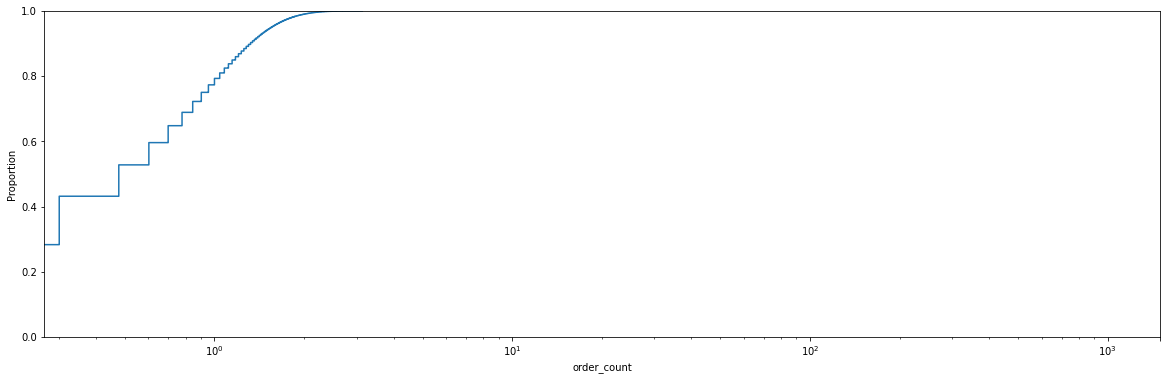

In [6]:
# plot the order count ecdf
fig, ax = plt.subplots(1, 1, figsize = (20, 6))
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax,
    log_scale=True
)
ax.set_xticks([1, 10, 100, 1000, 1500])
plt.show()

That is a target distribution we don't really want to see. Most orders are less than five and only a few orders have a significant number. We need to sample from more than just one month to make useful predictions.

# data cleanup

## train test split

In [7]:
# sample data for testing
products_sample_raw_df = products_all_raw_df.copy() #sample(20000)

In [8]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)

## data normalization

In [9]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash"]

In [10]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

## basic cleanup

In [11]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [12]:
# drop empty text
products_name_df.dropna(inplace=True)
products_description_df.dropna(inplace=True)

# replace everything but basic chars for now
products_name_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)
products_description_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)

# remove single and double characters
products_name_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_name_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_name_df["text"].replace("[ ]+", " ", inplace=True, regex=True)
products_description_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_name_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_name_df = products_name_df[products_name_df["text"] != ""]

products_description_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_description_df = products_description_df[products_description_df["text"] != ""]

In [13]:
# to lower
products_name_df["text"] = products_name_df["text"].str.lower()
products_description_df["text"] = products_description_df["text"].str.lower()

In [14]:
products_name_df

,product_id,vendor_id,vendor_geohash,text
407251,407251,131,w23bhdd,hudson eumenthol jujubes classic g
423373,423373,61,w21z675,kagi classic mini wafers
501111,501111,3621,w21z7r6,magnum mini almond multipack
12224,12224,383,w21zerf,plus active isotonic drink
244989,244989,842,w21zewm,oven baked seafood
...,...,...,...,...
576516,576516,183,w21zg1c,samurai beef special
485064,485064,2147,w21zkpx,hor fun
509311,509311,1953,w23b553,oyster omelette rice
437218,437218,383,w21zerf,storck nimm smilegummi fruit yogurt g


In [15]:
products_description_df

,product_id,vendor_id,vendor_geohash,text
299438,299438,1401,w21ztq6,cereal ice cream brownie marshmallow chocolate...
580315,580315,927,w21zg17,fluffy slice pandan chiffon cake
540692,540692,3473,w21zetv,rich full bodied espresso blended with milk an...
82897,82897,598,w23b1tr,spicy iconic favourite made for singapore since
226469,226469,9890,w21zmn6,expressive nose with cherry notes forest frui...
...,...,...,...,...
302351,302351,2107,w21zs0h,boxful white meat chicken beautifully battered
539469,539469,263,w21xxgg,this rich and creamy blend vanilla milk and ic...
177954,177954,11,w21z704,boxful white meat chicken beautifully battered
576516,576516,183,w21zg1c,savour the formidable taste samurai beef burge...


## tokenization and stemming

In [16]:
products_name_token_df = products_name_df.copy()
products_description_token_df = products_description_df.copy()

In [17]:
# tokenization
products_name_token_df["text_tokens"] = products_name_token_df["text"].transform(nltk.word_tokenize)
products_description_token_df["text_tokens"] = products_description_token_df["text"].apply(nltk.word_tokenize)

In [18]:
# add a position index and explode
products_name_token_df["idx"] = 1
products_name_token_df = products_name_token_df.explode("text_tokens")
products_name_token_df["idx"] = products_name_token_df.groupby(primary_keys)["idx"].cumsum()

products_description_token_df["idx"] = 1
products_description_token_df = products_description_token_df.explode("text_tokens")
products_description_token_df["idx"] = products_description_token_df.groupby(primary_keys)["idx"].cumsum()

In [19]:
# stemming which we will need later for word2vec
snowball = nltk.stem.SnowballStemmer(language="english")
products_name_token_df["text_tokens_stemmed"] = products_name_token_df["text_tokens"].apply(lambda x: snowball.stem(x))
products_description_token_df["text_tokens_stemmed"] = products_description_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

## filter english items

The general idea here is to count the fraction of english words in name and description and to use this in some way to filter english items.

### checking if tokens are english and couting etc.

In [20]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_name_token_df["is_english"] = products_name_token_df["text_tokens"].isin(words)
products_description_token_df["is_english"] = products_description_token_df["text_tokens"].isin(words)

In [21]:
products_english_df = products_df.copy()

# count english words and total words for product name
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "name_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "name_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# count english words and total words for product description
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "description_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "description_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# replace nans etc. from empty text and cast back to int
for col in ["name_is_english", "name_n_words", "description_is_english", "description_n_words"]:
    products_english_df[col] = products_english_df[col].replace(np.nan, 0).astype(int)

In [22]:
# calculate the actual frequency = score
products_english_df["total_is_english"] = products_english_df["name_is_english"] + products_english_df["description_is_english"]
products_english_df["total_n_words"] = products_english_df["name_n_words"] + products_english_df["description_n_words"]
products_english_df["english_score"] = products_english_df["total_is_english"] / products_english_df["total_n_words"]

In [23]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

### filter metric exploration

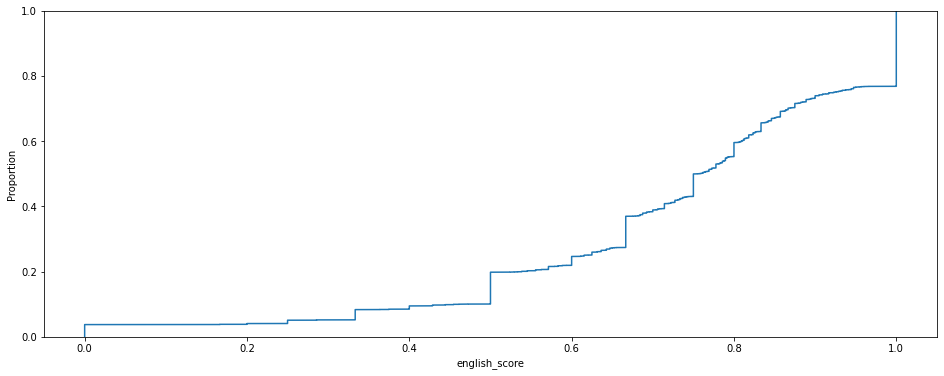

In [24]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

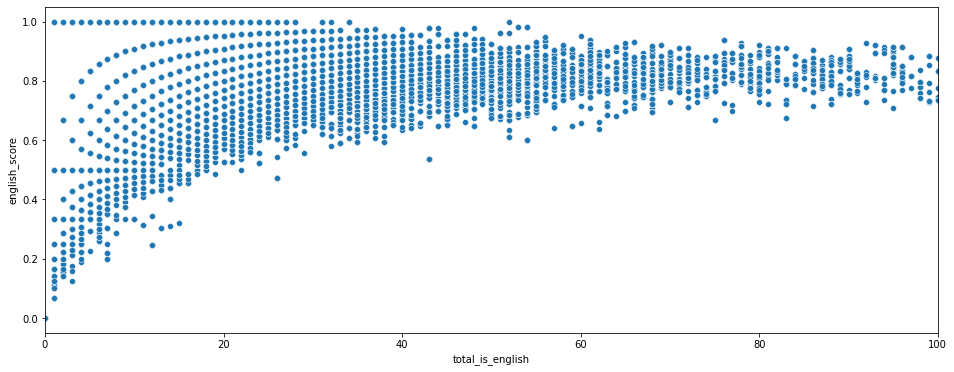

In [25]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.scatterplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

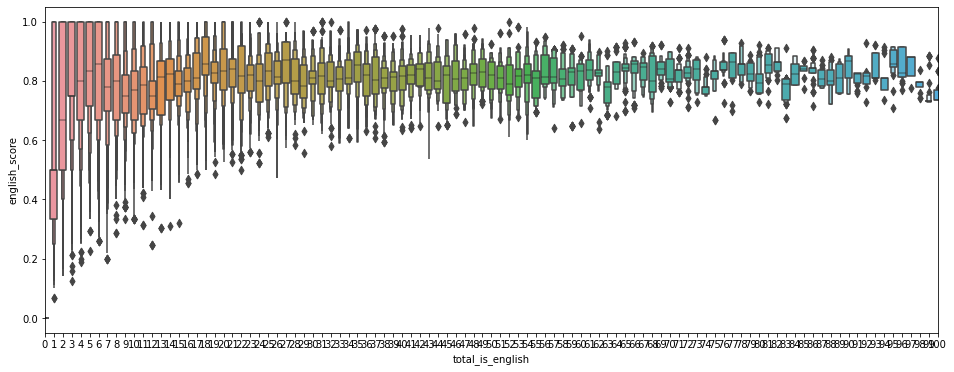

In [26]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.boxenplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

In [27]:
products_sample_raw_train_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,423373,61,w21z675,Kagi Classic Mini Wafers 125g,,4
1,238869,5115,w21ztnr,Mini Donut Chicken Burger,None,2
2,207434,7447,w21zdwx,Aburi Mekajiki Sushi,"2 Pcs, half broiled swordfish",1
3,519938,1436,w21z7qc,Chenna Masala,Chickpeas gravy,8
4,612828,1292,w21zs9m,Soto Ayam with Begedil,Soto ayam inclusive of begedil,17
...,...,...,...,...,...,...
5656,459392,1942,w21xxu6,DORITOS NACHO CHEESE LVL (5006678) | 92.1 g,None,5
5657,506198,1935,w21z8ss,NESTLE ALLENS FRUTIPS BLACKCURRANT (5001008) |...,None,7
5658,204644,8959,w21zep1,61284 Hansaplast Plasters - Plastic Strips 20's,None,1
5659,548822,3219,w21zg0p,13122097 Treats Ajitsuke Tamago 100g (Chilled),None,10


In [28]:
products_sample_raw_train_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,244989,842,w21zewm,E4. Oven Baked Seafood,None,2
1,21303,109,w21zc4v,Sayur Asam,Sweet and sour tamarind soup served with veget...,65
2,339269,4055,w21zsfe,Yeo's Bandung Rose Dk | 300 ml,None,3
3,94291,687,w21zt19,Veggie Delite™ Flatbread,A delightfully crunchy fresh combination of ga...,1
4,319140,7915,w21z718,Royal Oolong Latte,None,2
...,...,...,...,...,...,...
69476,536826,216,w21zscr,Peach Macchiato Large,None,9
69477,79623,2969,w21zv08,Sweet Lassi,A traditional dahi based beverage that include...,1
69478,14972,1543,w21zs80,Seafood Fried Rice,None,26
69479,258595,2837,w21z6um,Couple Set,"For 2 pax, comes with 2 pcs beef rendang, 2 pc...",2


In [29]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 0 ][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,350511,11287,w21zekc,Laksa 叻沙,None,3
1,213162,6368,w21zsds,Halia O,None,1
2,145375,6041,w23b4st,Kangkong Belacan,None,1
3,3124,1456,w23bh25,Nuggets (9 pcs),None,90
4,15028,1932,w23b4uy,E4. Kuey Teow Goreng Mamak,None,26
...,...,...,...,...,...,...
19100,24192,2666,w21ztq4,Zinger,None,24
19101,576432,608,w21ztjk,Masala Thosai,None,12
19102,334184,10267,w21zs0j,D4. French Fries,None,3
19103,114391,6721,w21xx32,Punjabi Samosa,None,1


In [30]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 1][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,423373,61,w21z675,Kagi Classic Mini Wafers 125g,,4
1,403732,1073,w21zfcs,CD6. Teh Gajah Ice,None,4
2,4054,1570,w21zkme,Masala Tea,None,28
3,558874,2075,w21zur6,Mee Hoon Goreng,None,10
4,46634,903,w21zs0h,5pc Chicken Tenders,None,60
...,...,...,...,...,...,...
57101,420421,4130,w21z8kr,12682977 M&M's Milk (40g),None,4
57102,404126,4084,w21zt4t,Chicken Biryani,None,4
57103,280809,5460,w21zvbb,Mayonnaise,None,2
57104,526268,2957,w21zgcs,Fried Beancurd 豆卜,100g,8


In [31]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 2][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,407251,131,w23bhdd,Hudson's Eumenthol Jujubes Classic 50g,,4
1,501111,3621,w21z7r6,MM001 | Magnum Mini Almond Multipack,None,7
2,244989,842,w21zewm,E4. Oven Baked Seafood,None,2
3,339269,4055,w21zsfe,Yeo's Bandung Rose Dk | 300 ml,None,3
4,319140,7915,w21z718,Royal Oolong Latte,None,2
...,...,...,...,...,...,...
80413,478142,1921,w23b4u5,Cheesy Pita,None,6
80414,127433,7105,w21zbzh,Bean Curd 大豆干,None,1
80415,476079,11026,w21z71k,Sayur Lodeh,Vegetable soup,6
80416,582483,2179,w21zkmv,Salted Butterscotch Brownies,None,13


In [32]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 3][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,628167,61,w21z675,Naturel Pure Olive Oil 750ml,0,21
1,144831,6730,w21zuhd,100 Plus Zero Sugar (8757) | 1.5 L,None,1
2,493547,3734,w21zbu0,152D. Chicken Ham Carbonara Spaghetti,None,6
3,117167,4074,w21zg1m,Assam Black Tea Medium,None,1
4,510382,341,w23b4z8,Pineapple Fried Rice 黄利炒饭,None,7
...,...,...,...,...,...,...
70403,384648,6684,w21z6bp,Winter Melon Bliss,None,3
70404,200065,5964,w21z8dx,B16 状元及第粥 Pig's Giblet Congee,None,1
70405,246454,713,w21zsc2,Maggi Hot Heads Spicy Curry | 64 g,None,2
70406,293446,7118,w21zc6e,Dried Fried Hor Fun 干炒河粉,None,2


Looks like the english score is not yet good enough. I'll stick for now to "at least one english word", which is also the easiest option. This can always be improved at a later stage.

### actual filtering

In [33]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["total_is_english"] > 0]

In [34]:
len(products_df), len(products_english_filtered_df)

(506518, 487281)

# cleanup verdict
Obviously we could improve our cleanup and subsequent filtering by a lot.

* better character level cleaning
* better dictionary (also include more culinary terms like croissant, alfredo, pepsi, some basic chinese dishes, etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)

For now it seems to be good enough.

# word2vec embedding

In [35]:
doc_keys = primary_keys + ["order_count"]

## gather data

In [36]:
products_name_doc_df = (products_english_filtered_df[doc_keys]
 .merge(products_name_token_df, on=primary_keys, how="inner")
 .groupby(doc_keys)["text_tokens_stemmed"]
 .agg(list)
 .reset_index()
 .rename({"text_tokens_stemmed": "name_tokens"}, axis=1))

In [37]:
products_description_doc_df = (products_english_filtered_df[doc_keys]
 .merge(products_description_token_df, on=primary_keys, how="inner")
 .groupby(doc_keys)["text_tokens_stemmed"]
 .agg(list)
 .reset_index()
 .rename({"text_tokens_stemmed": "description_tokens"}, axis=1))

In [38]:
products_doc_df = products_name_doc_df.merge(products_description_doc_df, on=doc_keys, how="left")
products_doc_df

,product_id,vendor_id,vendor_geohash,order_count,name_tokens,description_tokens
0,0,0,w21z6tu,116,"[chees, tofu]",NaN
1,1,1,w21z74d,30,"[naughti, nice, slice]","[chocol, slice]"
2,2,2,w21xxgu,25,"[pork, dumpl, with, hot, chilli, vinaigrett]","[pcs, spici]"
3,3,3,w23b4u1,45,"[mee, kuah]","[contain, minc, mutton, meat]"
4,4,4,w21ztq4,24,"[ham, chees, sandwich, set]","[toast, perfect, this, sandwich, hit, all, the..."
...,...,...,...,...,...,...
487257,633143,701,w21zkpm,22,"[sriracha, chicken, whole, wheat, pita]",NaN
487258,633144,17,w23b5j9,22,"[dettol, liquid, hand, wash, sensit]","[dettol, liquid, hand, wash, kill, germ, ensur..."
487259,633145,4135,w21ztw0,22,"[red, bean]",[pcs]
487260,633146,3121,w21z6vc,22,"[twister, meal]","[choic, twister, hash, brown, and, choic, drink]"


## train embedding

I will ignore hyperparameter tuning of Word2Vec for now.

In [39]:
w2v_names = gensim.models.Word2Vec(products_doc_df["name_tokens"])
w2v_descriptions = gensim.models.Word2Vec(products_doc_df["description_tokens"].dropna())

## inspect embedding

In [40]:
# look at name embedding
def plot_w2v_model(model):
  vectors = np.asarray(model.wv.vectors)
  labels = np.asarray(model.wv.index2entity)

  tsne = sklearn.manifold.TSNE(n_components=2)
  vectors = tsne.fit_transform(vectors)

  vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
  vectors_df["label"] = labels

  fig, ax = plt.subplots(1, 1, figsize=(20, 20))
  sns.scatterplot(
      data=vectors_df,
      x="x",
      y="y",
      ax=ax
  )
  for index, row in vectors_df.sample(100).iterrows():
    plt.annotate(
        s=row["label"],
        xy=(row["x"], row["y"])
    )
  plt.show()

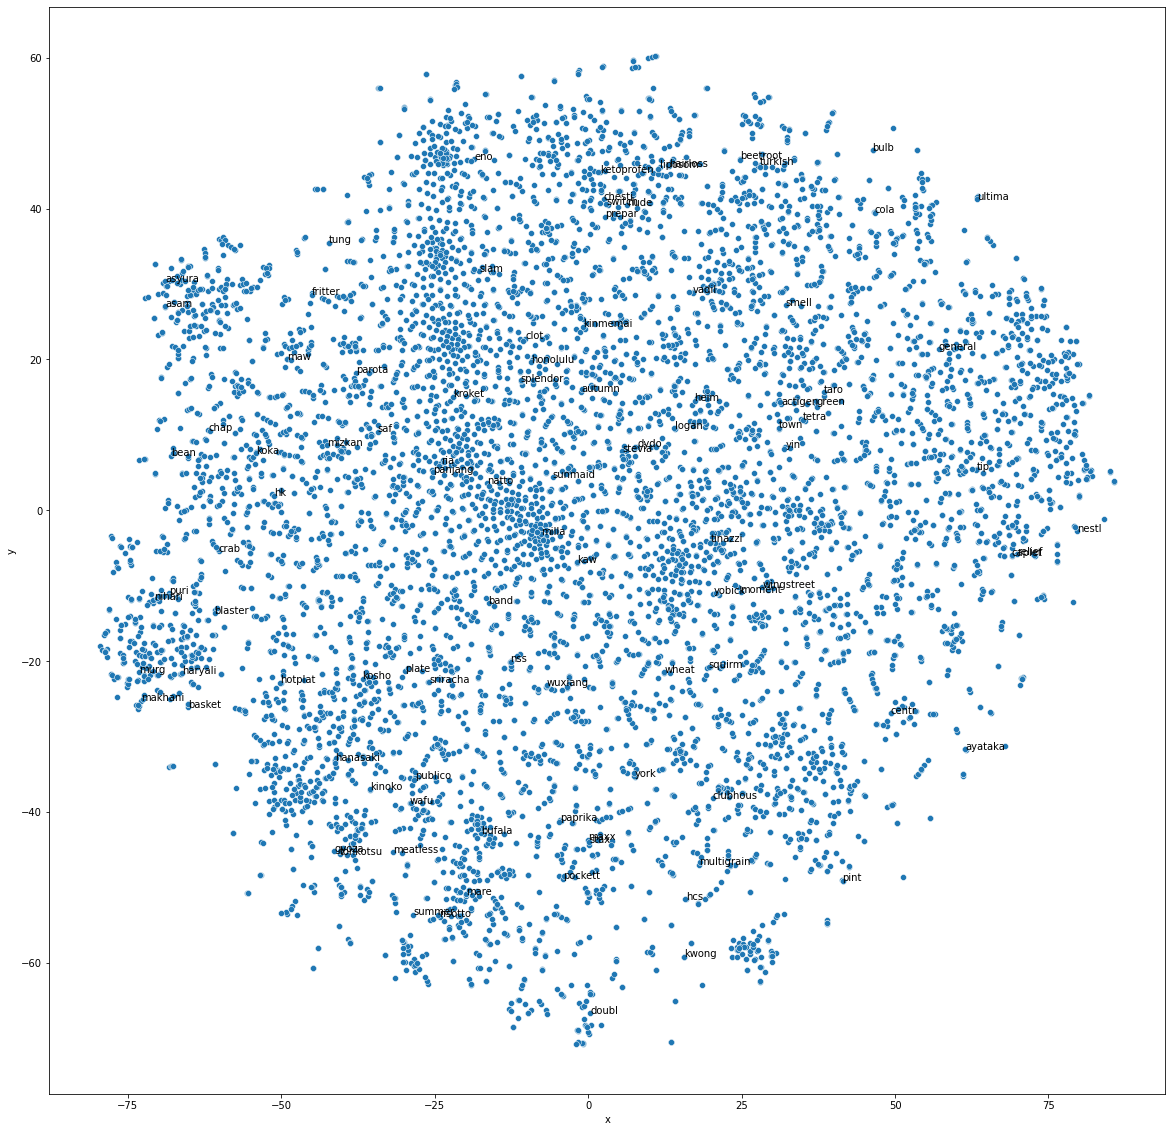

In [41]:
plot_w2v_model(w2v_names)

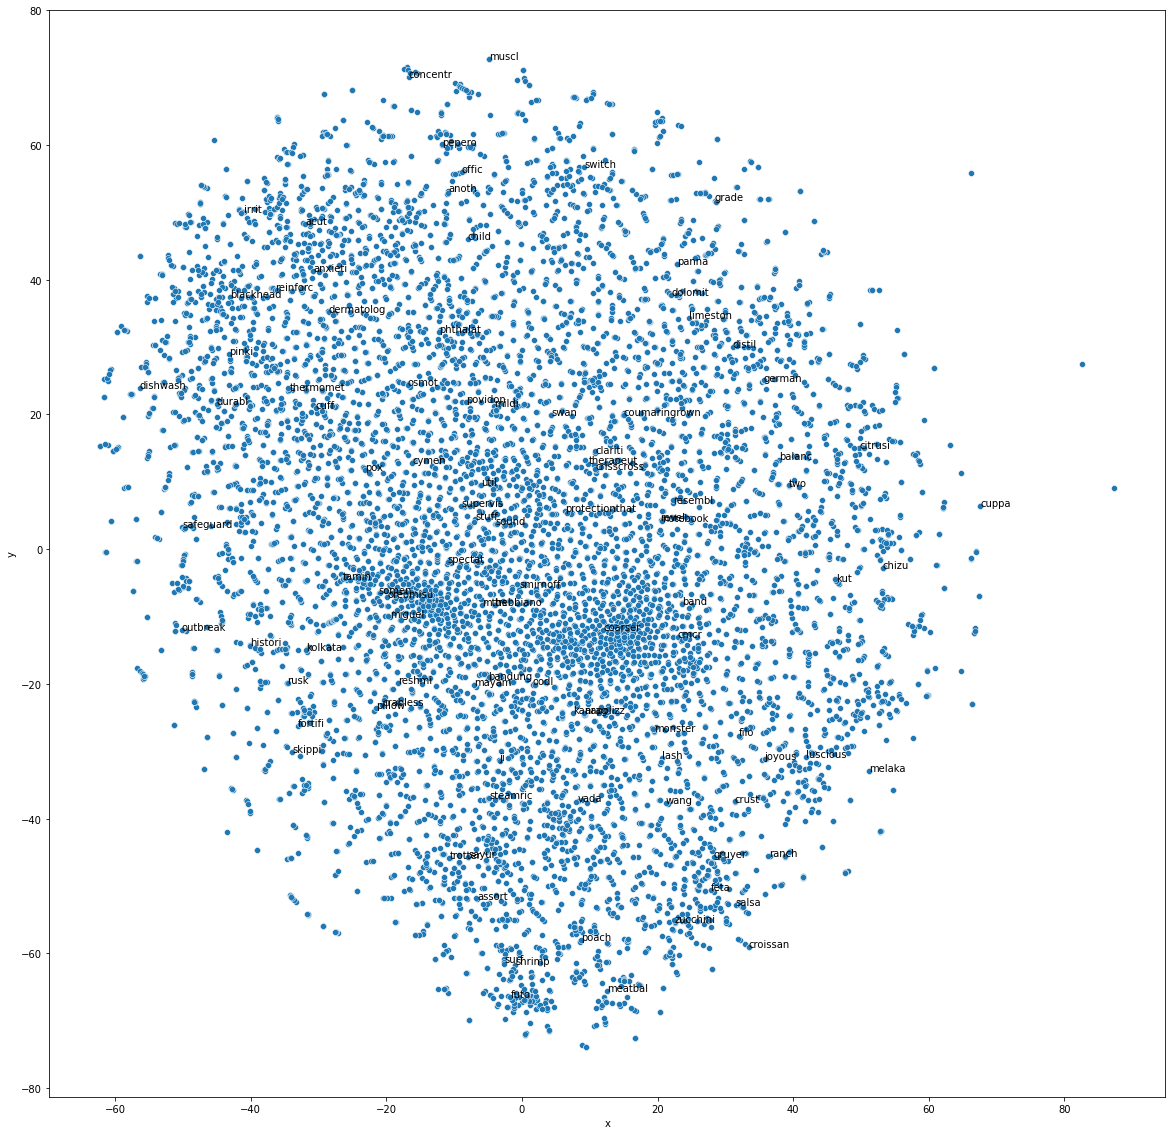

In [42]:
plot_w2v_model(w2v_descriptions)